# Computing the Lyapunov exponent

In this notebook, we compute the 

In [1]:
# Set environment variables 


import os

# Uncomment these lines to limit number of threads
#os.environ["OMP_NUM_THREADS"] = "4"         # OpenMP        # OpenMP: Used by NumPy, SciPy, and some C extensions
#os.environ["MKL_NUM_THREADS"] = "4"         # Intel MKL     # Intel MKL: Accelerates linear algebra in NumPy/SciPy (if installed).
#os.environ["OPENBLAS_NUM_THREADS"] = "4"    # OpenBLAS      # OpenBLAS: Alternative to MKL for matrix operations.
#os.environ["NUMBA_NUM_THREADS"] = "4"       # Numba (alternative to set_num_threads) # Numba: Parallel CPU execution (e.g., @njit(parallel=True)).


os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"


# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
from curraun.energy import Energy
from curraun.lyapunov import Lyapunov				# Edited 10.09.2025
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm
import copy

import datetime
from datetime import datetime                                           # Pooja
from time import time


import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd

from numba import set_num_threads
#set_num_threads(int(8))




start_time = datetime.now()
print("\nHello, the starting time is:", start_time)

#sys.exit()   


# ======================= VERIFICATION LINES FOR NO. OF THREADS =======================
from numba import get_num_threads
print("\nNumba threads:", get_num_threads())              # Should output the number given here: os.environ["NUMBA_NUM_THREADS"] = "4" 

# ????????????????????????????????? Doesn't work ????????????????????????????????? 
#print("NumPy max threads:", np.__config__.show())  # Should reflect your limit
#print("NumPy max threads:", np.__config__.get_info("max_threads"))  # Should reflect your limit     # The error occurs because np.__config__.get_info() doesn't exist in newer NumPy versions. 

# New way to check NumPy threading (works for all NumPy versions)
#try:
#    from threadpoolctl import threadpool_info
#    for lib in threadpool_info():
#        if lib['internal_api'] in ('openmp', 'mkl', 'openblas'):
#            print(f"{lib['internal_api'].upper()} threads:", lib['num_threads'])
#except ImportError:
#    print("Install threadpoolctl for detailed thread info: pip install threadpoolctl")
#    print("NumPy thread config:", np.__config__.show())

# =====================================================================================




N_Events  =  1                                                  # Number of events [Dimensionless]    
N_Sheets  =  1                                                  # Number of color sheets


# We compute everything for g²μ = 1 GeV and then rescale the results.
hbarc  =  0.197326                                          # hbar·c [GeV·fm]
g      =  2.0                                               # Coupling constant [Dimensionless]

g2mu   =  1.0                                               # g²μ [GeV]


mu     =  g2mu / (g**2)                                     # MV model parameter [GeV]
m_IR   =  0.00001                                           # No infrared regulation, except global charge neutrality [Pooja: Check units????????]
m_UV   =  100000.0                                          # UV regulator [GeV]
    
PI              =  np.pi    
Radius_Nucleus  =  67.7 * (hbarc/g2mu)                      # Radius of the nucleus [fm]
Area_Nucleus    =  PI * (Radius_Nucleus**2)                 # Transverse area of the nucleus [fm^2]

L                =  np.sqrt(Area_Nucleus)                   	# Length of the simulation box [fm]
#L                  =  6.4                                     	# Length of the simulation box [fm]
N_T                =  128					# Number of transverse lattice points [Dimensionless]

tau_max_g2mu_Latt  =  200.0					# tau_max * g²mu	(in lattice units [Dimensionless]) 		
								            # 30.0 for N = 4
N_TimeSteps_per_a  =  8						# Number of time steps per lattice spacing			[Dimensionless]



delta_x          =  L / N_T                                 # Lattice spacing [fm]     
a                =  delta_x					# Lattice spacing [fm] 



g2mu_a = g2mu * a                                           # g²μ*a  [GeV·fm]
g2mu_L = g2mu * L                                           # g²μ*L  [GeV·fm]

dk  =  2.0*PI / L                                           # Lattice momentum spacing  [fm⁻¹]

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++ Start: Units Conversion ++++++++++++++++++++++++++++++++++++++++++++++++ #
GeVfm_to_Latt         =  1.0/hbarc                      # GeV·fm to lattice units  [GeV·fm)⁻¹]
GeV_to_Latt           =  a/hbarc                        # GeV to lattice units     [GeV⁻¹]
fm_to_Latt            =  1.0/a							# fm to lattice units      [fm⁻¹]

GeVfmInverse_to_Latt  =  hbarc							# (GeV·fm)⁻¹ to lattice units  [GeV·fm]
GeVInverse_to_Latt    =  hbarc/a						# GeV⁻¹ to lattice units       [GeV]
fmInverse_to_Latt     =  a                              # fm⁻¹ to lattice units        [fm]

Latt_to_GeVfm         =  hbarc							# lattice units to GeV·fm  [GeV·fm]
Latt_to_GeV           =  hbarc/a                        # lattice units to GeV     [GeV]
Latt_to_fm    	      =  a                              # lattice units to fm      [fm]

Latt_to_GeVfmInverse  =  1.0/hbarc						# lattice units to (GeV·fm)⁻¹  [GeV·fm)⁻¹]
Latt_to_GeVInverse    =  a/hbarc						# lattice units to GeV⁻¹	   [GeV⁻¹]
Latt_to_fmInverse     =  1.0/a							# lattice units to fm⁻¹		   [fm⁻¹]
# ++++++++++++++++++++++++++++++++++++++++++++++++++ End: Units Conversion +++++++++++++++++++++++++++++++++++++++++++++++++ #
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #


tau_max_g2mu       =  tau_max_g2mu_Latt * Latt_to_GeVfm							# tau_max * g²mu				[GeV·fm]	
tau_max            =  tau_max_g2mu_Latt * (hbarc/g2mu)							# Maximum proper time, tau		[fm]  
tau_max_Latt       =  tau_max * fm_to_Latt										# Maximum proper time, tau		(in lattice units [Dimensionless]) 	


Nmax_TimeSteps    =  int(tau_max_Latt) * N_TimeSteps_per_a						# Total number of time steps involved in simulation	[Dimensionless]
																				# int: Keeps the value as integer

dtau        =  a / N_TimeSteps_per_a                                               # Time step size, dtau   [fm]
dtau_Latt   =  dtau * fm_to_Latt                                                   # Time step size, dtau   (in lattice units [Dimensionless])

d_tau_Latt  =  1 / N_TimeSteps_per_a                                               # Time step size, d_tau  (in lattice units [Dimensionless])
d_tau       =  d_tau_Latt * Latt_to_fm                                             # Time step size, d_tau  [fm]  





# ========================================================================================================================== #
# =========================================== Start: Parameters in Lattice Units =========================================== #

g_Latt      =  g                                            # Coupling constant [Dimensionless]
hbarc_Latt  =  hbarc * GeVfm_to_Latt                        # hbar*c in lattice units [Dimensionless], hbarc_Latt = 1
g2mu_Latt   =   g2mu * GeV_to_Latt
mu_Latt     =     mu * GeV_to_Latt
m_IR_Latt   =   m_IR * GeV_to_Latt
m_UV_Latt   =   m_UV * GeV_to_Latt


Radius_Nucleus_Latt  =  Radius_Nucleus *fm_to_Latt              # Radius of the nucleus (in lattice units [Dimensionless])
Area_Nucleus_Latt    =  Area_Nucleus * (fm_to_Latt**2)          # Transverse area of the nucleus (in lattice units [Dimensionless])

a_Latt = a * fm_to_Latt                                         # Lattice spacing [Dimensionless],   a_latt = 1
L_Latt = L * fm_to_Latt                                         # Length of the simulation box (in lattice units [Dimensionless])

g2mu_a_Latt = g2mu_a * GeVfm_to_Latt                            # g²μ*a (in lattice units [Dimensionless])
g2mu_L_Latt = g2mu_L * GeVfm_to_Latt                            # g²μ*L (in lattice units [Dimensionless])

dk_Latt  =  dk * fmInverse_to_Latt                              # Lattice momentum spacing	[lattice units] [Dimensionless]

# ============================================ End: Parameters in Lattice Units ============================================ #
# ========================================================================================================================== #





# ========================================================================================================================================================================== #
# ======================================================================= Start: Lyapunov Parameters ======================================================================= #
Option_Fluctuations_EL_BL = 2                                           # 1: Include fluctuations in EL          
                                                                        # 2: Include fluctuations in BL

Option_Noise_Type = 2                                                   # 0: No noise
                                                                        # 1: Exponential noise
                                                                        # 2: Power-law noise
                                                                        # 3: Independent noise (Theta/Shell function)

Lypnv_alpha  =  0.001                                                              # [Dimensionless]

                              
Option_Noise_Units = 1                                                                                    # 0: Define parameters in physical units, then convert to lattice units
                                                                                                                # 1: Define parameters in lattice units, then convert to physical units    



if(Option_Noise_Units == 0):
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Exponential and Power-law Noise: Physical to Lattice Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_PL_EXP_M_Noise_Scale    =  0.5                                                    # Scaling factor, M_Noise_Scale for the Exponential and Power-Law Noise     [Dimensionless]  
    Lypnv_PL_EXP_M_Noise          =  Lypnv_PL_EXP_M_Noise_Scale * g2mu                      # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT [GeV]         
    Lypnv_PL_EXP_M_Noise_by_g2mu  =  Lypnv_PL_EXP_M_Noise / g2mu                            # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              [Dimensionless]

    Lypnv_PL_EXP_M_Noise_Latt          =  Lypnv_PL_EXP_M_Noise * GeV_to_Latt                # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT (in lattice units [Dimensionless])   
    Lypnv_PL_EXP_M_Noise_by_g2mu_Latt  =  Lypnv_PL_EXP_M_Noise_by_g2mu                      # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              (in lattice units [Dimensionless])
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Independent Noise (Theta function): Physical to Lattice Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_THETA_K_Scale                =  20.0                                                                   # Scaling factor, K_Scale for the Theta Noise       [Dimensionless]

    Lypnv_THETA_dk_Shell               =  2.0*dk                                                                # Shell thickness, dk_Shell for the Theta Noise     [fm⁻¹]
    Lypnv_THETA_K_Centre               =  Lypnv_THETA_K_Scale * Lypnv_THETA_dk_Shell                            # Centre of the shell, K_Centre for the Theta Noise [fm⁻¹]
    Lypnv_THETA_K_Centre_by_g2mu       =  Lypnv_THETA_K_Centre / g2mu                                           # K_Centre/g²μ for the Theta Noise                  [GeV·fm)⁻¹]

    Lypnv_THETA_dk_Shell_Latt          =  Lypnv_THETA_dk_Shell * fmInverse_to_Latt                              # Shell thickness, dk_Shell for the Theta Noise     (in lattice units [Dimensionless])
    Lypnv_THETA_K_Centre_Latt          =  Lypnv_THETA_K_Centre * fmInverse_to_Latt                              # Centre of the shell, K_Centre for the Theta Noise (in lattice units [Dimensionless]) 
    Lypnv_THETA_K_Centre_by_g2mu_Latt  =  Lypnv_THETA_K_Centre_by_g2mu * GeVfmInverse_to_Latt                   # K_Centre/g²μ for the Theta Noise                  (in lattice units [Dimensionless])    
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""




elif(Option_Noise_Units == 1):
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Exponential and Power-law Noise: Lattice to Physical Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_PL_EXP_M_Noise_by_g2mu_Latt  =  0.5                                                                  # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              (in lattice units [Dimensionless])
    Lypnv_PL_EXP_M_Noise_Latt          =  Lypnv_PL_EXP_M_Noise_by_g2mu_Latt * g2mu_Latt                         # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT (in lattice units [Dimensionless])  
    Lypnv_PL_EXP_M_Noise_Scale         =  Lypnv_PL_EXP_M_Noise_Latt / g2mu_Latt                                 # Scaling factor, M_Noise_Scale for the Exponential and Power-Law Noise     [Dimensionless]     

    Lypnv_PL_EXP_M_Noise_by_g2mu       =  Lypnv_PL_EXP_M_Noise_by_g2mu_Latt                                     # M_Noise/g²μ for Exponential and Power-Law Noise, used in FFT              [Dimensionless] 
    Lypnv_PL_EXP_M_Noise               =  Lypnv_PL_EXP_M_Noise_Latt * Latt_to_GeV                               # Noise parameter, M_Noise for Exponential and Power-Law Noise, used in FFT [GeV] 
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Parameters for Independent Noise (Theta function): Lattice to Physical Units """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Lypnv_THETA_K_Centre_by_g2mu_Latt  =  0.12                                                                   # K_Centre/g²μ for the Theta Noise                  (in lattice units [Dimensionless])
    Lypnv_THETA_K_Centre_Latt          =  Lypnv_THETA_K_Centre_by_g2mu_Latt * g2mu_Latt                         # Centre of the shell, K_Centre for the Theta Noise (in lattice units [Dimensionless]) 
    Lypnv_THETA_dk_Shell_Latt          =  2.0*dk_Latt                                                           # Shell thickness, dk_Shell for the Theta Noise     (in lattice units [Dimensionless])    
    Lypnv_THETA_K_Scale                =  Lypnv_THETA_K_Centre_Latt / Lypnv_THETA_dk_Shell_Latt                 # Scaling factor, K_Scale for the Theta Noise       [Dimensionless]

    Lypnv_THETA_K_Centre_by_g2mu       =  Lypnv_THETA_K_Centre_by_g2mu_Latt * Latt_to_GeVfmInverse              # K_Centre/g²μ for the Theta Noise                  [GeV·fm)⁻¹]
    Lypnv_THETA_K_Centre               =  Lypnv_THETA_K_Centre_Latt * Latt_to_fmInverse                         # Centre of the shell, K_Centre for the Theta Noise [fm⁻¹] 
    Lypnv_THETA_dk_Shell               =  Lypnv_THETA_dk_Shell_Latt * Latt_to_fmInverse                         # Shell thickness, dk_Shell for the Theta Noise     [fm⁻¹]           
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""




""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Formatting strings for plotting and filenames """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
alpha_String      =  f"{Lypnv_alpha:.6f}".rstrip('0').rstrip('.')

if Option_Noise_Type == 0:
    Noise_Type = "No noise"
    Noise_Type_String = "None"
    Noise_Value_String = f"{1.0:.1f}" 


elif Option_Noise_Type == 1:
    Noise_Type = "Exponential noise"
    Noise_Type_String = "EXP"
    Noise_Value_String = f"{Lypnv_PL_EXP_M_Noise_by_g2mu_Latt:.1f}" 

elif Option_Noise_Type == 2:
    Noise_Type = "Power-law noise"
    Noise_Type_String = "PL"
    Noise_Value_String = f"{Lypnv_PL_EXP_M_Noise_by_g2mu_Latt:.1f}" 

elif Option_Noise_Type == 3:
    Noise_Type = "Independent noise, Theta/Shell function"
    Noise_Type_String = "THETA"
    Noise_Value_String = f"{Lypnv_THETA_K_Centre_by_g2mu_Latt:.1f}" 
   
else:
    print("\nError: Option_Noise_Type not recognized")
    sys.exit(1)
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# ======================================================================== End: Lyapunov Parameters ======================================================================== #
# ========================================================================================================================================================================== #





print("\n")

print(" ================================================================================================ ")
print(" ============================== Conversion Factors (Mutiplicative) ============================== ")
print(f"GeV·fm to lattice units      = {GeVfm_to_Latt:12.6f}")
print(f"GeV to lattice units         = {GeV_to_Latt:12.6f}")
print(f"fm to lattice units          = {fm_to_Latt:12.6f}\n")
print(f"(GeV·fm)⁻¹ to lattice units  = {GeVfmInverse_to_Latt:12.6f}")
print(f"GeV⁻¹ to lattice units       = {GeVInverse_to_Latt:12.6f}")
print(f"fm⁻¹ to lattice units        = {fmInverse_to_Latt:12.6f}\n")

print(f"lattice units to GeV·fm      = {Latt_to_GeVfm:12.6f}")
print(f"lattice units to GeV         = {Latt_to_GeV:12.6f}")
print(f"lattice units to fm          = {Latt_to_fm:12.6f}\n")
print(f"lattice units to (GeV·fm)⁻¹  = {Latt_to_GeVfmInverse:12.6f}")
print(f"lattice units to GeV⁻¹       = {Latt_to_GeVInverse:12.6f}")
print(f"lattice units to fm⁻¹        = {Latt_to_fmInverse:12.6f}")
print(" ================================================================================================ ")
print(" ================================================================================================\n ")


print(f"hbarc                = {hbarc:12.6f} GeV·fm          = {hbarc_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"g²μ                  = {g2mu:12.6f} GeV             = {g2mu_Latt:12.6f} (in lattice units [Dimensionless])\n")
print(f"Coupling constant, g = {g:12.6f} [Dimensionless]")
print(f"μ                    = {mu:12.6f} GeV             =   {mu_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"m_IR                 = {m_IR:12.6f} GeV             =   {m_IR_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"m_UV                 = {m_UV:12.6f} GeV            =   {m_UV_Latt:12.6f} (in lattice units [Dimensionless])\n")

print(f"PI                   = {PI:12.6f}\n")

print(f"Radius of the nucleus, Radius_Nucleus         = {Radius_Nucleus:12.6f} fm      =   {Radius_Nucleus_Latt:12.6f} (in lattice units [Dimensionless])")  
print(f"Transverse area of the nucleus, Area_Nucleus  = {Area_Nucleus:12.6f} fm^2    =   {Area_Nucleus_Latt:12.6f} (in lattice units [Dimensionless])\n")

print(f"Number of lattice points, Nₜ      = {N_T:12d}")
print(f"Length of the simulation box, L    = {L:12.6f} fm    =   {L_Latt:8.2f} (in lattice units [Dimensionless])")
print(f"Lattice spacing, delta_x           = {a:12.6f} fm    =   {a_Latt:8.2f} (in lattice units [Dimensionless])\n")

print(f"g²μ.a  = {g2mu*a:12.6f} GeV·fm     =   {g2mu_a_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"g²μ.L  = {g2mu*L:12.6f} GeV·fm     =   {g2mu_L_Latt:12.6f} (in lattice units [Dimensionless])\n")

print(f"Lattice momentum spacing, dk  = {dk:12.6f} fm⁻¹   = {dk_Latt:12.8f} (in lattice units [Dimensionless])\n")


print(f"Maximum proper time, τₘₐₓ·g²μ                       = {tau_max_g2mu:12.6f} GeV·fm            = {tau_max_g2mu_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"Maximum proper time, τₘₐₓ                           = {tau_max:12.6f} fm                = {tau_max_Latt:12.6f} (in lattice units [Dimensionless])\n")
print(f"Time steps per lattice spacing, N_TimeSteps_per_a   = {N_TimeSteps_per_a:12d} [Dimensionless]")
print(f"Total number of time steps, N_TimeStepsₘₐₓ          = {Nmax_TimeSteps:12d} [Dimensionless]\n")

print(f"Time step size, dτ                                  = {dtau:12.6f} fm         =   {dtau_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"Time step size, d_τ                                 = {d_tau:12.6f} fm         =   {d_tau_Latt:12.6f} (in lattice units [Dimensionless])\n")

print(" ================================================================================================ ")
print(" ====================================== Lyapunov Parameters ===================================== ")
print(f"Noise Type                             = {Noise_Type_String:>12s}")
print(f"Lyapunov perturbation, alpha           = {Lypnv_alpha:12.6f} [Dimensionless]\n")

print(f"PL/EXP Noise scale factor, M_Scale     = {Lypnv_PL_EXP_M_Noise_Scale:12.6f} [Dimensionless]")
print(f"PL/EXP Noise parameter,    M_Noise     = {Lypnv_PL_EXP_M_Noise:12.6f} GeV              = {Lypnv_PL_EXP_M_Noise_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"PL/EXP M_Noise/g²μ                     = {Lypnv_PL_EXP_M_Noise_by_g2mu:12.6f} [Dimensionless]  = {Lypnv_PL_EXP_M_Noise_by_g2mu_Latt:12.6f} (in lattice units [Dimensionless])\n")

 
print(f"THETA Noise scale factor, K_Scale      = {Lypnv_THETA_K_Scale:12.6f} [Dimensionless]")
print(f"THETA Shell thickness,   dk_Shell      = {Lypnv_THETA_dk_Shell:12.6f} fm⁻¹             = {Lypnv_THETA_dk_Shell_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"THETA Shell center,      K_Centre      = {Lypnv_THETA_K_Centre:12.6f} fm⁻¹             = {Lypnv_THETA_K_Centre_Latt:12.6f} (in lattice units [Dimensionless])")
print(f"THETA K_Centre/g²μ                     = {Lypnv_THETA_K_Centre_by_g2mu:12.6f} (GeV·fm)⁻¹       = {Lypnv_THETA_K_Centre_by_g2mu_Latt:12.6f} (in lattice units [Dimensionless])\n")  

print(f"Noise Type String                      = {Noise_Type_String:>12s}")
print(f"alpha String                           = {alpha_String:>12s}")
print(f"Noise Value String                     = {Noise_Value_String:>12s}")

print(" ================================================================================================ ")
print(" ================================================================================================\n ")








""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" Start: Dictionary for Glasma Parameters """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Glasma_Parameters_Dictionary = {    
    'N_Events'                 : N_Events,                                # Number of events [Dimensionless]
    'N_Sheets'                 : N_Sheets,                                # Number of color sheets [Dimensionless]

    'L'                        : L,                                       # Transverse size of lattice [fm]
    'L_Latt'                   : L_Latt,                                  # Transverse size of lattice [lattice units]

    'N_T'                      : N_T,                                     # Number of lattice points [Dimensionless]

    'a'                        : a,                                       # Lattice spacing [fm]
    'a_Latt'                   : a_Latt,                                  # Lattice spacing [lattice units]

    'dk'                       : dk,                                      # Lattice momentum spacing [fm⁻¹]
    'dk_Latt'                  : dk_Latt,                                 # Lattice momentum spacing [lattice units]

    'g'                        : g,                                       # YM coupling constant [Dimensionless]
    'g2mu'                     : g2mu,                                    # g²μ [GeV]
    'g2mu_Latt'                : g2mu_Latt,                               # g²μ [lattice units]
    'g2mu_a'                   : g2mu_a,                                  # g²μ·a [GeV·fm]
    'g2mu_a_Latt'              : g2mu_a_Latt,                             # g²μ·a [lattice units]
    'g2mu_L'                   : g2mu_L,                                  # g²μ·L [GeV·fm]
    'g2mu_L_Latt'              : g2mu_L_Latt,                             # g²μ·L [lattice units]

    'mu'                       : mu,                                      # MV model parameter [GeV]
    'mu_Latt'                  : mu_Latt,                                 # MV model parameter [lattice units]

    'M_IR'                     : m_IR,                                    # IR regulator [GeV]
    'm_IR_Latt'                : m_IR_Latt,                               # IR regulator [lattice units]
   
    'M_UV'                     : m_UV,                                    # UV regulator [GeV]
    'M_UV_Latt'                : m_UV_Latt,                               # UV regulator [lattice units]


    'tau_max'                  : tau_max,                                 # Maximum proper time, τₘₐₓ [fm]
    'tau_max_Latt'             : tau_max_Latt,                            # Maximum proper time, τₘₐₓ [lattice units]
    'tau_max_g2mu'             : tau_max_g2mu,                            # τₘₐₓ·g²μ [GeV·fm]
    'tau_max_g2mu_Latt'        : tau_max_g2mu_Latt,                       # τₘₐₓ·g²μ [lattice units]

    'N_t_a'                    : N_TimeSteps_per_a,                       # Time steps per lattice spacing [Dimensionless]
    'N_t_max'                  : Nmax_TimeSteps,                          # Total number of time steps [Dimensionless]

    'dtau'                     : dtau,                                    # Time step size, dτ  [fm]
    'dtau_Latt'                : dtau_Latt,                               # Time step size, dτ  [lattice units]
    'd_tau'                    : d_tau,                                   # Time step size, d_τ [fm]
    'd_tau_Latt'               : d_tau_Latt,                              # Time step size, d_τ [lattice units]

    'Ly_Option_Noise_Type'     : Option_Noise_Type,                       # Noise type option [Dimensionless]
    'Ly_alpha'                 : Lypnv_alpha,                             # Lyapunov perturbation parameter [Dimensionless]

    'Ly_M_Noise_Scale'         : Lypnv_PL_EXP_M_Noise_Scale,              # Noise scale factor [Dimensionless]

    'Ly_M_noise_phy'           : Lypnv_PL_EXP_M_Noise,                    # Noise parameter for FFT [GeV]
    'Ly_M_noise_latt'          : Lypnv_PL_EXP_M_Noise_Latt,               # Noise parameter for FFT [lattice units]

    'Ly_M_Noise_by_g2mu'       : Lypnv_PL_EXP_M_Noise_by_g2mu,            # M_Noise/g²μ [Dimensionless]
    'Ly_M_Noise_by_g2mu_latt'  : Lypnv_PL_EXP_M_Noise_by_g2mu_Latt,       # M_Noise/g²μ [lattice units]

    'Ly_K_Scale'               : Lypnv_THETA_K_Scale,                     # K scale factor [Dimensionless]

    'Ly_K_centre_phy'          : Lypnv_THETA_K_Centre,                    # Center of the shell [fm⁻¹]
    'Ly_K_centre_latt'         : Lypnv_THETA_K_Centre_Latt,               # Center of the shell [lattice units]

    'Ly_dk_shell_phy'          : Lypnv_THETA_dk_Shell,                    # Shell thickness [fm⁻¹]
    'Ly_dk_shell_latt'         : Lypnv_THETA_dk_Shell_Latt,               # Shell thickness [lattice units]
    
    'Ly_K_Centre_by_g2mu'      : Lypnv_THETA_K_Centre_by_g2mu,            # K_Centre/g²μ [(GeV·fm)⁻¹]
    'Ly_K_Centre_by_g2mu_latt' : Lypnv_THETA_K_Centre_by_g2mu_Latt,       # K_Centre/g²μ [lattice units]


    'GeVfm_to_Latt'            : GeVfm_to_Latt,                           # GeV·fm to lattice units  [GeV·fm)⁻¹]
    'GeV_to_Latt'              : GeV_to_Latt,                             # GeV to lattice units     [GeV⁻¹]
    'fm_to_Latt'               : fm_to_Latt,                              # fm to lattice units      [fm⁻¹]

    'GeVfmInverse_to_Latt'     : GeVfmInverse_to_Latt,                    # (GeV·fm)⁻¹ to lattice units [GeV·fm]
    'GeVInverse_to_Latt'       : GeVInverse_to_Latt,                        # GeV⁻¹ to lattice units    [GeV]
    'fmInverse_to_Latt'        : fmInverse_to_Latt,                       # fm⁻¹ to lattice units       [fm]

    'Latt_to_GeVfm'            : Latt_to_GeVfm,                           # lattice units to GeV·fm  [GeV·fm]
    'Latt_to_GeV'              : Latt_to_GeV,                             # lattice units to GeV     [GeV]
    'Latt_to_fm'               : Latt_to_fm,                              # lattice units to fm      [fm]

    'Latt_to_GeVfmInverse'     : Latt_to_GeVfmInverse,                    # lattice units to (GeV·fm)⁻¹ [GeV·fm)⁻¹]
    'Latt_to_GeVInverse'       : Latt_to_GeVInverse,                        # lattice units to GeV⁻¹    [GeV⁻¹]
    'Latt_to_fmInverse'        : Latt_to_fmInverse,                       # lattice units to fm⁻¹       [fm⁻¹]  
}

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" End: Dictionary for Glasma Parameters """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""





def compute(p):    
    
    output = {}                                                                                     # Output dictionary to store output data

    output["energy"], output["pL"] , output["pT"]  = [], [], []
    output["EL"], output["BL"], output["ET"], output["BT"] = [], [], [], []

    output["energyp"], output["pLp"] , output["pTp"]  = [], [], []
    output["ELp"], output["BLp"], output["ETp"], output["BTp"] = [], [], [], []

    output["ratio_dif"]          = []
    output["ratio_dif_variance"] = []
    output["ratio_dif_std"]      = []
    output["ratio_dif_error"]    = []

    output["ratio_difalpha2"]          = []
    output["ratio_difalpha2_variance"] = []
    output["ratio_difalpha2_std"]      = []
    output["ratio_difalpha2_error"]    = []

    

    start_tau = 1
    
    for i_Event in range(N_Events):                                                                                      
        print("\nSimulating event {} of {}".format(i_Event +1, N_Events), "at  ", datetime.now().strftime("%d-%m-%Y %H:%M:%S")  ) 

        # Initialization
        s = core.Simulation(N_T, dtau_Latt, g)

        Va = mv.wilson( s,   mu = mu_Latt,   m = m_IR_Latt,   uv = m_UV_Latt,  num_sheets = N_Sheets )
        Vb = mv.wilson( s,   mu = mu_Latt,   m = m_IR_Latt,   uv = m_UV_Latt,  num_sheets = N_Sheets )        
        initial.init(s, Va, Vb)

        en = Energy(s)                                              # initialize energy computation

        

        # ************************* Start: Lyapunov Exponents  *************************
        sprime = copy.deepcopy(s)                                   # copy of s        
        enp = Energy(sprime)                                        # ed for sprime        
        ly = Lyapunov(s, sprime)                                    # initialize Lyapunov computation        
        

        alpha     =  p["Ly_alpha"]        
        m_noise   =  p["Ly_M_noise_latt"]                                       # Added 23.04.2025
        K_centre  =  p["Ly_K_centre_latt"]                                      # Added 10.09.2025
        dk        =  p["Ly_dk_shell_latt"]                                      # Added 10.09.2025

        """        
        print("m_noise        =", m_noise)                  
        print("alpha          =", alpha)             
        print("K_centre      =", K_centre)             
        print("dk            =", dk)         
        """
 

        if(Option_Fluctuations_EL_BL == 1):
            ly.change_EL(Option_Noise_Type, alpha, m_noise, K_centre, dk)                                   # Added 10.09.2025
        elif(Option_Fluctuations_EL_BL == 2):
            ly.change_Ui(Option_Noise_Type, alpha, m_noise, K_centre, dk)                                   # Added 10.09.2025
        else:
            print("\nError: Option_Fluctuations_EL_BL not recognized")
            sys.exit(1)
        # ************************* End: Lyapunov Exponents  *************************


        energy,  pL,  pT,  EL,  BL,  ET,  BT  = [], [], [], [], [], [], []
        energyp, pLp, pTp, ELp, BLp, ETp, BTp = [], [], [], [], [], [], []
        	
        ratio_dif_list = []
        taus = []                                                                               # taus: An empty list that will be used to store time step number during the simulation                            


        # !!!!!!!!!!!!!!!!!!!!!! For GPU computation !!!!!!!!!!!!!!!!!!!!!!
        if use_cuda:

            s.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


        for i_tau in tqdm(range(Nmax_TimeSteps)):                   # Time evolution loop    : i_tau = 0, 1, 2, ..., Nmax_TimeSteps-1   
        #for i_tau in range(Nmax_TimeSteps):                                                                                                                                                                   
       

            #print("i_tau =", i_tau, "of", Nmax_TimeSteps, (i_tau+1) * dtau )

            core.evolve_leapfrog(s)

            # evole sprime copy of s with el changed
            core.evolve_leapfrog(sprime)

            if i_tau >= start_tau:
                units = Latt_to_GeV ** 2 / (s.g ** 2)                               # Unit factors (GeV³)

                # color factors (for quarks)
                Nc = core.su.NC
                f = 2 * s.g ** 2 / (2 * Nc)



                """
                # Energy density calculation for s and sprime
                en.compute()
                enp.compute()



                Latt_to_GeV4        =  Latt_to_GeV ** 4                             # lattice units to GeV⁴
                Latt_to_GeV_by_fm3  =  Latt_to_GeV4 / (hbarc ** 3)                  # lattice units to GeV/fm³

                # unit factors (GeV^3) 
                EL.append(en.EL_mean * Latt_to_GeV4)
                BL.append(en.BL_mean * Latt_to_GeV4)
                ET.append(en.ET_mean * Latt_to_GeV4)
                BT.append(en.BT_mean * Latt_to_GeV4)

                ELp.append(enp.EL_mean * Latt_to_GeV4)
                BLp.append(enp.BL_mean * Latt_to_GeV4)
                ETp.append(enp.ET_mean * Latt_to_GeV4)
                BTp.append(enp.BT_mean * Latt_to_GeV4)

                
                energy.append(en.energy_density * Latt_to_GeV_by_fm3)               # Unit factors (GeV/fm³)
                pL.append(en.pL * Latt_to_GeV_by_fm3)
                pT.append(en.pT * Latt_to_GeV_by_fm3)

                energyp.append(enp.energy_density * Latt_to_GeV_by_fm3)
                pLp.append(enp.pL * Latt_to_GeV_by_fm3)
                pTp.append(enp.pT * Latt_to_GeV_by_fm3)
                """


                if(Option_Fluctuations_EL_BL == 1):
                    ly.compute_change_EL()
                    ratio_dif_list.append(ly.ratio_EL_dif)

                elif(Option_Fluctuations_EL_BL == 2):
                    ly.compute_change_BL()
                    ratio_dif_list.append(ly.ratio_BL_dif)

                else:
                    print("\nError: Option_Fluctuations_EL_BL not recognized")
                    sys.exit(1)


                taus.append(i_tau)

        """
        energy = np.array(energy)                                                                               # Converts the Python list energy to a NumPy array
                                                                                                                # List  version look like: [1,  2,  3,  4]
                                                                                                                # NumPy version look like: [1  2  3  4] (no commas)
        
        EL = np.array(EL)                                                                                     # Converts the Python list EL to a NumPy array
        ET = np.array(ET)                                                                                     # Converts the Python list ET to a NumPy array
        BL = np.array(BL)                                                                                     # Converts the Python list BL to a NumPy array
        BT = np.array(BT)                                                                                     # Converts the Python list BT to a NumPy array
        pL = np.array(pL)                                                                                     # Converts the Python list pL to a NumPy array
        pT = np.array(pT)                                                                                     # Converts the Python list pT to a NumPy array

        energyp = np.array(energyp)
        ELp = np.array(ELp)                                                                                   # Converts the Python list ELp to a NumPy array
        ETp = np.array(ETp)                                                                                   # Converts the Python list ETp to a NumPy array
        BLp = np.array(BLp)                                                                                   # Converts the Python list BLp to a NumPy array
        BTp = np.array(BTp)                                                                                   # Converts the Python list BTp to a NumPy array
        pLp = np.array(pLp)                                                                                   # Converts the Python list pLp to a NumPy array
        pTp = np.array(pTp)                                                                                   # Converts the Python list pTp to a NumPy array
        

        #EL, BL, ET, BT = np.array(EL), np.array(BL), np.array(ET), np.array(BT)
        #ELp, BLp, ETp, BTp = np.array(ELp), np.array(BLp), np.array(ETp), np.array(BTp)

        #pL, pT = np.array(pL), np.array(pT)
        #pLp, pTp = np.array(pLp), np.array(pTp)


        output["energy"].append(energy)

        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)

        output["pL"].append(pL)
        output["pT"].append(pT)

        output["energyp"].append(energyp)

        output["ELp"].append(ELp)
        output["BLp"].append(BLp)
        output["ETp"].append(ETp)
        output["BTp"].append(BTp)

        output["pLp"].append(pLp)
        output["pTp"].append(pTp)


        """



        # ************************* Lyapunov Exponents  *************************
       
        ratio_dif_array = np.array(ratio_dif_list)

        output["ratio_dif"].append(ratio_dif_array)
        output["ratio_difalpha2"].append(ratio_dif_array/(alpha**2.0))        # Computed variance of the ratio_dif
        # ************************* Lyapunov Exponents  *************************

    # perform average over events
    
    # also add standard deviations

    # output["energy_std"] = np.std(np.array(output["energy"]), axis=0)    
    # output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    # output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    # output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    # output["BT_std"] = np.std(np.array(output["BT"]), axis=0)    
    # output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    # output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    """
    # compute means
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)


    output["energyp"] = np.mean(np.array(output["energyp"]), axis=0)

    output["ELp"] = np.mean(np.array(output["ELp"]), axis=0)
    output["BLp"] = np.mean(np.array(output["BLp"]), axis=0)
    output["ETp"] = np.mean(np.array(output["ETp"]), axis=0)
    output["BTp"] = np.mean(np.array(output["BTp"]), axis=0)
    
    output["pLp"] = np.mean(np.array(output["pLp"]), axis=0)
    output["pTp"] = np.mean(np.array(output["pTp"]), axis=0)

    """



    # ************************* Lyapunov Exponents  *************************
    output["ratio_dif_variance"] = np.var(np.array(output["ratio_dif"]), axis=0)        # Computed variance of the ratio_dif
    output["ratio_dif_std"]      = np.std(np.array(output["ratio_dif"]), axis=0)        # Calculate variance and standard deviation of the ratio_dif before calculating mean because otherwise it will be wrong due to file names changed
    output["ratio_dif_error"   ] = np.std(np.array(output["ratio_dif"]), axis=0)/np.sqrt(N_Events)      # Error
    output["ratio_dif"]          = np.mean(np.array(output["ratio_dif"]), axis=0)


    output["ratio_difalpha2_variance"] = np.var(np.array(output["ratio_difalpha2"]), axis=0)    
    output["ratio_difalpha2_std"]      = np.std(np.array(output["ratio_difalpha2"]), axis=0)    
    output["ratio_difalpha2_error"   ] = np.std(np.array(output["ratio_difalpha2"]), axis=0)/np.sqrt(N_Events)    
    output["ratio_difalpha2"]          = np.mean(np.array(output["ratio_difalpha2"]), axis=0)


    """
    print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    print("\n output[\"ratio_difalpha2\"]          = ", output["ratio_difalpha2"])
   
    print("\n output[\"ratio_dif_variance\"] = ", output["ratio_dif_variance"])
    print("\n output[\"ratio_difalpha2_variance\"] = ", output["ratio_difalpha2_variance"])

    print("\n output[\"ratio_dif_std\"]      = ", output["ratio_dif_std"])
    print("\n output[\"ratio_difalpha2_std\"]      = ", output["ratio_difalpha2_std"])

    print("\n output[\"ratio_dif_error\"]          = ", output["ratio_dif_error"])
    print("\n output[\"ratio_difalpha2_error\"]          = ", output["ratio_difalpha2_error"])  
    """

    #print("\n output[\"energyp\"]  = ", output["energyp"])


    #print("\n output[\"energyp\"]  = ", output["energyp"])


    
    """
    print("\n output[\"ratio_dif\"]          = ", output["ratio_dif"])
    print("\n output[\"ratio_dif_variance\"] = ", output["ratio_dif_variance"])  
    print("\n output[\"ratio_dif_std\"]      = ", output["ratio_dif_std"])
    """
    # ************************* Lyapunov Exponents  *************************
    

    #print("taus after time loop, taulist: \n", taus)



    i_tau      =  np.array(taus)                                            # Convert the Python list taus to a NumPy array of time steps
                                                                            # taus: [1,  2,  3,  4 ...., Nmax_TimeSteps-1]
                                                                            # i_tau: [1  2  3  4 ....  Nmax_TimeSteps-1] (no commas)

    i_max_tau  =  np.max(i_tau)                                             # Maximum value of time step simulated (Nmax_TimeSteps-1) in the "i_tau" NumPy array
    #i_max_tau  =  np.max(taus)                                             # Maximum value of time step simulated (Nmax_TimeSteps-1) in the "taus" list

    delta_tau   = p["tau_max"] / i_max_tau                                  # Proper time step size, Δτ [fm]

    output["tau"]            =  i_tau * delta_tau                           # NumPy array of the proper times (τ) at which Glasma is simulated [fm]
    output["tau_g2mu"]       =  output["tau"] * p["g2mu"]                   # NumPy array of the τ·g²μ at which Glasma is simulated [GeV·fm]
    output["tau_Latt"]       =  output["tau"] * fm_to_Latt                  # NumPy array of the proper times (τ) at which Glasma is simulated (in lattice units [Dimensionless])
    output["tau_g2mu_Latt"]  =  output["tau_g2mu"] * GeVfm_to_Latt          # NumPy array of the τ·g²μ at which Glasma is simulated (in lattice units [Dimensionless])



    """
    print("i_tau Array = ", i_tau)
    print("i_max_tau   = ", i_max_tau)
    print("p[tau_max]  = ", p["tau_max"], "fm")
    print("delta_tau   =", delta_tau)

    print("output[tau] in fm = \n", output["tau"], "\n\n")
    print("output[tau_g2mu] in GeVfm = \n", output["tau_g2mu"], "\n\n")

    print("output[tau_Latt] = \n", output["tau_Latt"], "\n\n")
    print("output[tau_g2mu_Latt] = \n", output["tau_g2mu_Latt"], "\n\n")
    #output["tau"] = np.array(taus) / np.max(taus) * p["tau_max"]                # [fm]


    print("i_max_time\n", i_max_tau, "\n\nnp.max(taus)\n", np.max(taus))
    print("i_tau\n", i_tau, "\n\nnp.array(taus)\n", np.array(taus))

    """




    output["Latt_to_GeV"] = Latt_to_GeV


    #print("output[Latt_to_GeV]  = \n", output["Latt_to_GeV"])



    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output






# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
start_time = datetime.now()                 # datetime.now() gets the current date and time from your system. 
                                            # It returns a datetime object (which contains year, month, day, hour, minute, second, etc.).
                                            # Next, store that value in the variable present_time.
start_time_formatted = start_time.strftime("%d-%m-%Y %H:%M:%S")     # .strftime() means “string format time” 
                                                                        # It convertS a datetime object into a string, in your given format.
print("Hello, the start time is:   ", start_time_formatted, "\n")


t1 = time()

Glasma_Simulation = compute(Glasma_Parameters_Dictionary)

t2 = time()

Elapsed_time = t2 - t1                                                  # Added by Pooja
print(f"\nElapsed time: {Elapsed_time: 10.2f} seconds")                 # Added by Pooja

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #





Glasma = Glasma_Simulation

tau            =  Glasma["tau"]       
tau_g2mu       =  Glasma["tau_g2mu"]          
tau_Latt       =  Glasma["tau_Latt"]          
tau_g2mu_Latt  =  Glasma["tau_g2mu_Latt"]          




# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
end_time = datetime.now()
end_time_formatted = end_time.strftime("%d-%m-%Y %H:%M:%S") 
print("\nHello, the end time is:   ", end_time_formatted)

elapsed_time = end_time - start_time

# Extract days, hours, minutes, seconds, and microseconds
days = elapsed_time.days
hours = elapsed_time.seconds // 3600
minutes = (elapsed_time.seconds % 3600) // 60
seconds = elapsed_time.seconds % 60
microseconds = elapsed_time.microseconds

elapsed_time_formatted = f"{days:02} days, {hours:02} hrs, {minutes:02} mins, {seconds:02} secs"        # Format the elapsed time
print(f"\nElapsed time:\n", elapsed_time, "  =  ", elapsed_time_formatted )                   
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


print("\nGlasma Simulation completed successfully!")
print("Proceed to plot the results.\n")


# ================================================================================ Saving files for plotting ================================================================================ #
# =========================================================================================================================================================================================== #
x1        =  Glasma["tau_g2mu_Latt"]                                                       
y1        =  Glasma["ratio_dif"] 
y1_var    =  Glasma["ratio_dif_variance"]
y1_std    =  Glasma["ratio_dif_std"]
y1_error  =  Glasma["ratio_dif_error"]                                 # np.sqrt(y1_var/N_Events)    # Calculate the error bars using the variance

x2        =  Glasma["tau_g2mu_Latt"] 
y2        =  Glasma["ratio_difalpha2"]
y2_var    =  Glasma["ratio_difalpha2_variance"]
y2_std    =  Glasma["ratio_difalpha2_std"]
y2_error  =  Glasma["ratio_difalpha2_error"]                           # np.sqrt(y2_var/N_Events)                                                       
# =========================================================================================================================================================================================== #


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ Generating dynamic labels and file names +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
if Option_Noise_Type == 0:
    label_dynamic = rf"$Noise~Type = {Noise_Type_String}$, $N^{T} = {N_T}$, $\alpha = {alpha_String}$, $N_{{events}} = {N_Events}$"

    if(Option_Fluctuations_EL_BL == 1):
        data_filename1 = f"data_tau_diffEeta_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Nevents{N_Events}.csv"  
        data_filename2 = f"data_tau_diffEetaalpha2_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Nevents{N_Events}.csv"   
    elif(Option_Fluctuations_EL_BL == 2):
        data_filename1 = f"data_tau_diffBeta_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Nevents{N_Events}.csv"  
        data_filename2 = f"data_tau_diffBetaalpha2_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Nevents{N_Events}.csv"   
    else:
        print("\nError: Option_Fluctuations_EL_BL not recognized")
        sys.exit(1)
  
    print("\nNo noise case. \n")
    print("data_filename1", data_filename1)
    print("data_filename2", data_filename2)


if Option_Noise_Type in [1, 2, 3]:
    label_dynamic = rf"$Noise~Type = {Noise_Type_String}$, $N = {N_T}$, $\alpha = {alpha_String}$, $Noise^{{Latt}} = {Noise_Value_String} $, $N_{{events}} = {N_Events}$"

    if(Option_Fluctuations_EL_BL == 1):
        data_filename1 = f"data_tau_diffEeta_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Noise{Noise_Value_String}_Nevents{N_Events}.csv"  
        data_filename2 = f"data_tau_diffEetaalpha2_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Noise{Noise_Value_String}_Nevents{N_Events}.csv"       
    elif(Option_Fluctuations_EL_BL == 2):
        data_filename1 = f"data_tau_diffBeta_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Noise{Noise_Value_String}_Nevents{N_Events}.csv"  
        data_filename2 = f"data_tau_diffBetaalpha2_Noise{Noise_Type_String}_N{N_T}_alpha{alpha_String}_Noise{Noise_Value_String}_Nevents{N_Events}.csv"       
    else:
        print("\nError: Option_Fluctuations_EL_BL not recognized")
        sys.exit(1)

    print("\nWith noise case. \n")      
    print("data_filename1: ", data_filename1)
    print("data_filename2: ", data_filename2)

    # label_dynamic = rf"$Noise~Type = {Noise_Type_String}$, $N = {N}$, $\alpha = {alpha_String}$, $m_{{noise}}^{{phy}} = {Noise_Value_String}~ g²\mu$, $N_{{events}} = {N_Events}$"
    # label_dynamic = rf"$Noise~Type = {Noise_Type_String}$, $N = {N}$, $\alpha = {alpha_String}$, $K^{{phy}} = { Noise_Value_String} \Delta k$, $N_{{events}} = {N_Events}$"
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++





Using Numba
Using SU(2)
Using double precision
Using double precision
Using double precision

Hello, the starting time is: 2025-10-17 13:42:15.892322

Numba threads: 8


 ============================== Conversion Factors (Mutiplicative) ============================== 
GeV·fm to lattice units      =     5.067756
GeV to lattice units         =     0.937462
fm to lattice units          =     5.405826

(GeV·fm)⁻¹ to lattice units  =     0.197326
GeV⁻¹ to lattice units       =     1.066710
fm⁻¹ to lattice units        =     0.184986

lattice units to GeV·fm      =     0.197326
lattice units to GeV         =     1.066710
lattice units to fm          =     0.184986

lattice units to (GeV·fm)⁻¹  =     5.067756
lattice units to GeV⁻¹       =     0.937462
lattice units to fm⁻¹        =     5.405826
 
hbarc                =     0.197326 GeV·fm          =     1.000000 (in lattice units [Dimensionless])
g²μ                  =     1.000000 GeV             =     0.937462 (in lattice units [Dimensionl

100%|██████████| 1704/1704 [00:12<00:00, 139.46it/s]


Elapsed time:      23.61 seconds

Hello, the end time is:    17-10-2025 13:42:39

Elapsed time:
 0:00:23.607583   =   00 days, 00 hrs, 00 mins, 23 secs

Glasma Simulation completed successfully!
Proceed to plot the results.


With noise case. 

data_filename1:  data_tau_diffBeta_NoisePL_N128_alpha0.001_Noise0.5_Nevents1.csv
data_filename2:  data_tau_diffBetaalpha2_NoisePL_N128_alpha0.001_Noise0.5_Nevents1.csv


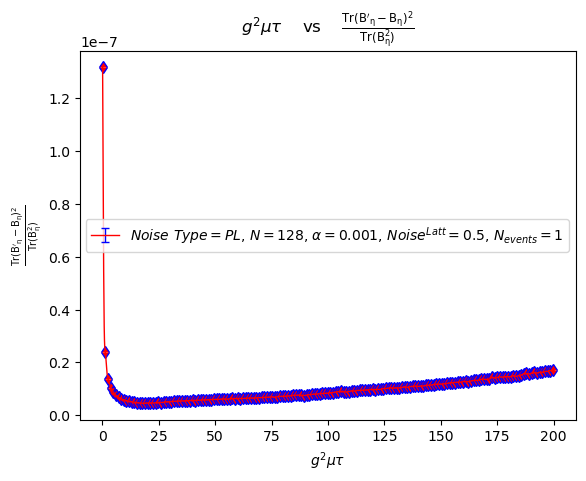

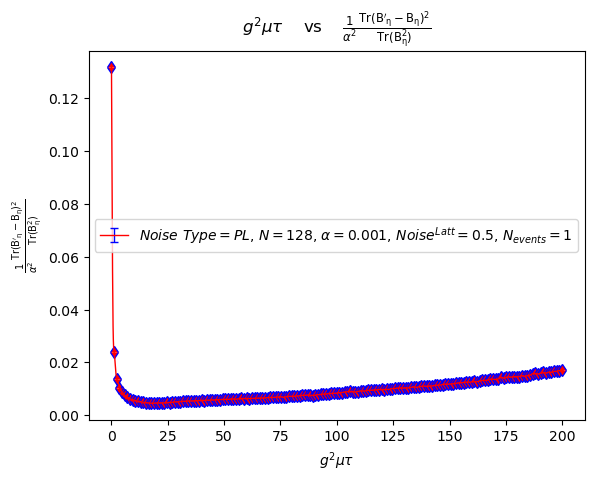

In [2]:


#          Plot g^2 \mu \tau         vs          Tr(E' - E)^2/Tr(E^2)        
plt.errorbar(x1, y1, y1_error,   label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)

if(Option_Fluctuations_EL_BL == 1):
    plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
    plt.ylabel(r"$\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
elif(Option_Fluctuations_EL_BL == 2):
    plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")            # Plot title
    plt.ylabel(r"$\mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")
else:
    print("\nError: Option_Fluctuations_EL_BL not recognized")
    sys.exit(1)

plt.xlabel(r"$g^2 \mu \tau$")

#plt.xlim(0.0, 200)                                                                                                  # To change the x scale       
#plt.ylim(0.0, 0.00000001)                                                                                           # To change the y scale      
plt.legend()
plt.show()




#          Plot g^2 \mu \tau         vs          1/\alpha^2  Tr(E' - E)^2/Tr(E^2)
plt.errorbar(x2, y2, y2_error,   label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)

if(Option_Fluctuations_EL_BL == 1):
    plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")           
    plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")
elif(Option_Fluctuations_EL_BL == 2):
    plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")           
    plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")
else:
    print("\nError: Option_Fluctuations_EL_BL not recognized")
    sys.exit(1)

plt.xlabel(r"$g^2 \mu \tau$")

#plt.xlim(0.0, 200)                                                                                                       
#plt.ylim(0.0, 1)                                                                                              
plt.legend()
plt.show()

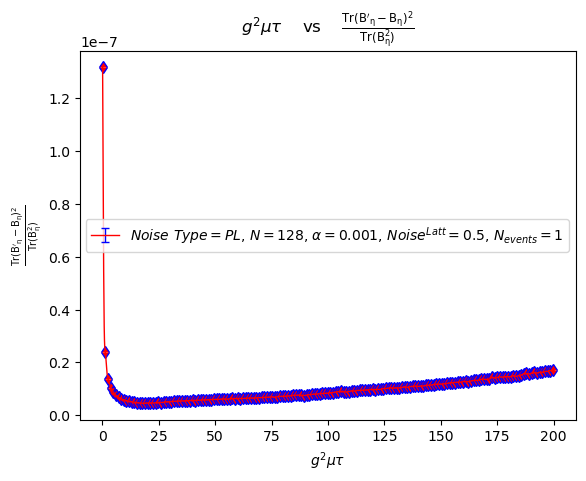

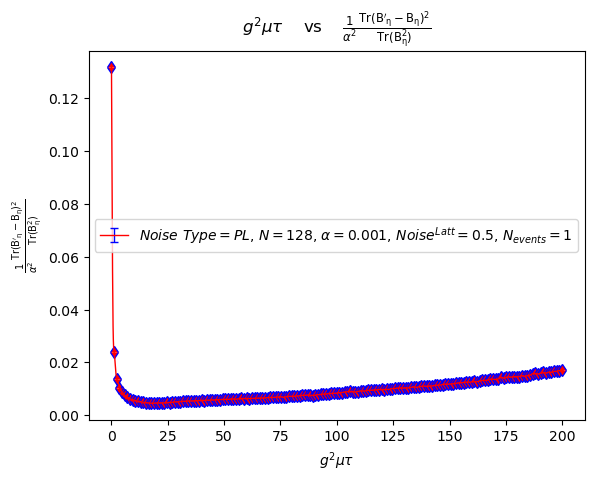


Hello, this code is done! Hurray!!!

Hello, the time now is: 2025-10-17 13:42:40.424737


In [3]:







# Saving data to a CSV file and plotting from file using pandas

# Create a DataFrame
if(Option_Fluctuations_EL_BL == 1):
    df1 = pd.DataFrame({
    "tau": x1,
    "diff_Eeta": y1,
    "diff_Eeta_variance": y1_var,
    "diff_Eeta_std": y1_std,
    "diff_Eeta_error": y1_error,
    "N_Events": N_Events,   })

    df2 = pd.DataFrame({
    "tau": x2,
    "diff_Eetaalpha2": y2,
    "diff_Eetaalpha2_variance": y2_var,
    "diff_Eetaalpha2_std": y2_std,
    "diff_Eetaalpha2_error": y2_error,
    "N_Events": N_Events,}) 

elif(Option_Fluctuations_EL_BL == 2):
    df1 = pd.DataFrame({
    "tau": x1,
    "diff_Beta": y1,
    "diff_Beta_variance": y1_var,
    "diff_Beta_std": y1_std,
    "diff_Beta_error": y1_error,
    "N_Events": N_Events,   })

    df2 = pd.DataFrame({
    "tau": x2,
    "diff_Betaalpha2": y2,
    "diff_Betaalpha2_variance": y2_var,
    "diff_Betaalpha2_std": y2_std,
    "diff_Betaalpha2_error": y2_error,
    "N_Events": N_Events,})

else:
    print("\nError: Option_Fluctuations_EL_BL not recognized")
    sys.exit(1)

   

df1.to_csv(data_filename1, index=False)                                                                                 # Save the DataFrame to a CSV file
df1 = pd.read_csv(data_filename1)                                                                                       # Read the CSV file into a DataFrame




if(Option_Fluctuations_EL_BL == 1):
    plt.errorbar(df1["tau"], df1["diff_Eeta"], df1["diff_Eeta_error"], label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)

    plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")            # Plot title
    plt.ylabel(r"$\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")

elif(Option_Fluctuations_EL_BL == 2):
    plt.errorbar(df1["tau"], df1["diff_Beta"], df1["diff_Beta_error"], label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)

    plt.title(r"$g^2 \mu \tau$    vs    $\mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")            # Plot title
    plt.ylabel(r"$\mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")
else:
    print("\nError: Option_Fluctuations_EL_BL not recognized")
    sys.exit(1)

plt.xlabel(r"$g^2 \mu \tau$")

#plt.xlim(0.0, 200)                                                                                                    
#plt.ylim(0.0, 0.00000001)                                                                                              
plt.legend()
plt.show()



df2.to_csv(data_filename2, index=False)                                                                                
df2 = pd.read_csv(data_filename2)


if(Option_Fluctuations_EL_BL == 1):
    plt.errorbar(df2["tau"], df2["diff_Eetaalpha2"], df2["diff_Eetaalpha2_error"], label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)

    plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")           
    plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(E'_{\eta} - E_{\eta})^2}{Tr(E_{\eta}^2)} }$")

elif(Option_Fluctuations_EL_BL == 2):
    plt.errorbar(df2["tau"], df2["diff_Betaalpha2"], df2["diff_Betaalpha2_error"], label=label_dynamic,  errorevery=10,  linewidth=1, linestyle="solid", color="red", ecolor="blue", elinewidth=1,  uplims=True, lolims=True)#, capsize=3, capthick=1)

    plt.title(r"$g^2 \mu \tau$    vs    $ \frac{1}{\alpha^2} \mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")           
    plt.ylabel(r"$ \frac{1}{\alpha^2}\mathrm {\frac{Tr(B'_{\eta} - B_{\eta})^2}{Tr(B_{\eta}^2)} }$")
else:
    print("\nError: Option_Fluctuations_EL_BL not recognized")
    sys.exit(1)
    
plt.xlabel(r"$g^2 \mu \tau$")

#plt.xlim(0.0, 200)											       
#plt.ylim(0.0, 1)											     
plt.legend()
plt.show()



# ===================================================================================================================================================== #
# ===================================================================================================================================================== #



print("\nHello, this code is done! Hurray!!!")


print("\nHello, the time now is:", datetime.now())